#Imports

In [ ]:
pip install adversarial-robustness-toolbox

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import art

#Global Variables

* This is for convenience so that we can easily map the results of the classifications to their proper label.

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


#Util Functions

* All the util functions to help prevent code repetition. All are self explanatory. 

In [ ]:

def show_image(image, label=None):
  
  class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

  plt.figure(figsize=(15,15))
  plt.subplot(5,5,1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
  if label != None:
   plt.xlabel(class_names[label[0]])
  plt.show()


def get_label(model_prediction):
  """given the prediction of a model this function 
  prints out the associated label"""

  return class_names[np.argmax(model_prediction)]

def get_confidence(classifier, example):

  """Gets confidence levels for predictions"""
  
  pred = classifier.predict(example)
  label = np.argmax(pred,axis=1)
  confidence = np.max(pred, axis=1)

  print('label:',class_names[label[0]],'confidence:',confidence[0])

def get_attack_name(attack):
  """Returns attack name"""
  return str(attack).split('.')[3]

def get_attack_type(attack):
  """Returns attack type"""
  return str(attack).split('.')[2]
  
def get_defense_name(defense):
  """Returns defense name"""
  return str(defense).split('.')[3]

def get_defense_type(defense):
  """Returns defense type"""
  return str(defense).split('.')[2]

#Data

In [ ]:
#loading data
(x_train,y_train),(x_test,y_test) = keras.datasets.cifar10.load_data()

In [ ]:
#normalizing data
x_train = x_train/255
x_test = x_test/255 


In [ ]:
#getting even number of classes and storing them in x_subsample and y_subsample
x_subsample = np.reshape(np.array([]),(0,32,32,3))
y_subsample = np.reshape(np.array([],dtype='int'),(0,1))

for i in range(len(np.unique(y_test))):
  
  index = (y_test==i).reshape(10000)
  x_subsample = np.append(x_subsample,x_test[index][:10],axis=0)
  y_subsample = np.append(y_subsample, y_test[index][:10],axis=0)
  

The code below is just to show that there are in fact 10 examples from each class in the subsample. 

In [ ]:
#showing that there are 10 examples from each class
from collections import Counter

Counter(np.reshape(y_subsample,(100)))

Counter({0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10})

Just to check that the training examples match the labels 

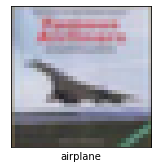

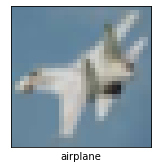

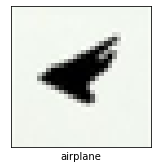

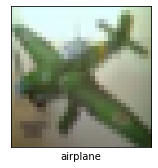

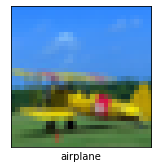

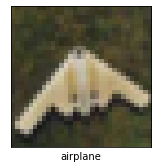

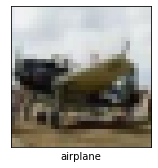

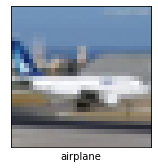

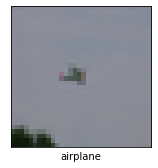

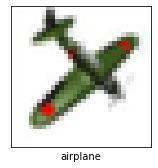

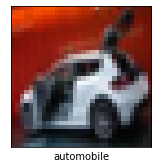

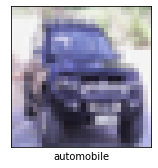

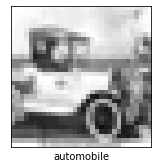

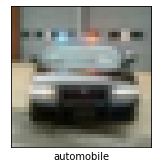

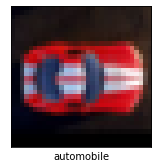

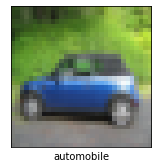

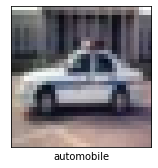

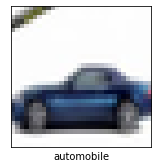

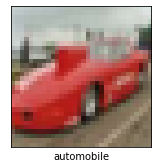

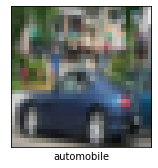

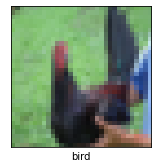

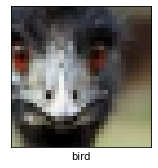

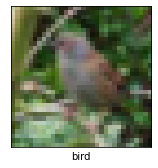

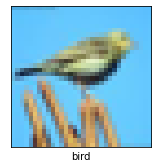

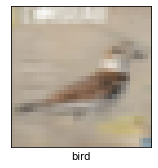

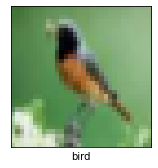

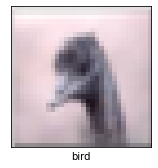

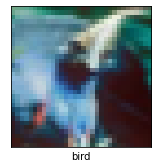

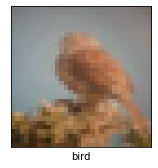

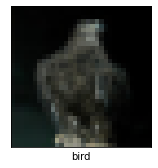

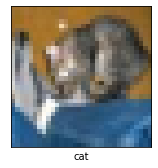

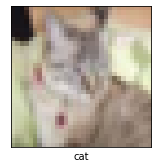

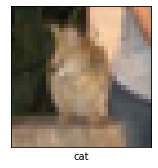

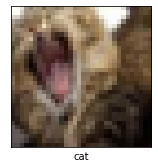

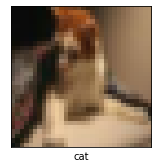

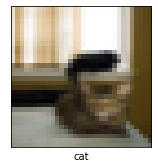

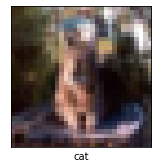

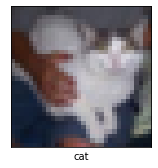

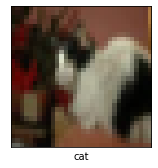

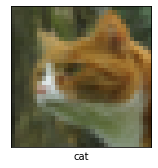

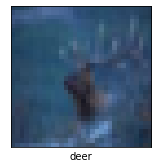

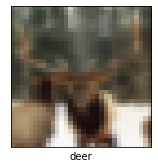

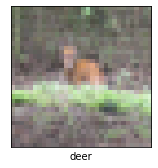

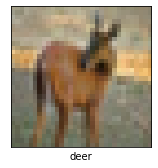

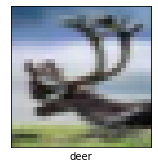

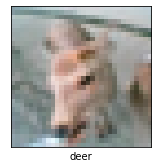

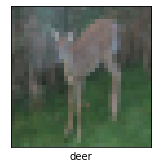

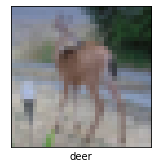

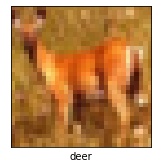

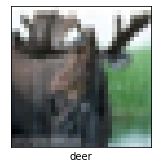

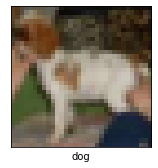

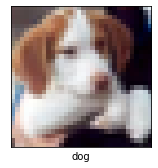

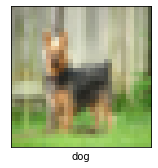

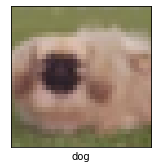

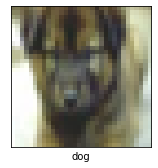

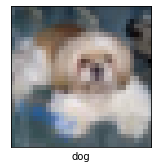

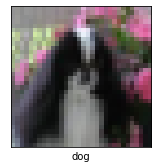

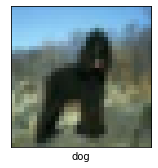

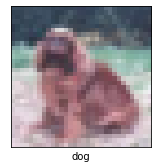

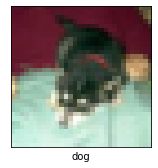

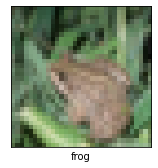

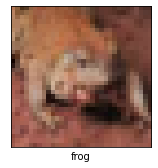

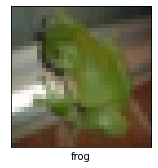

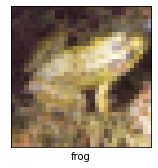

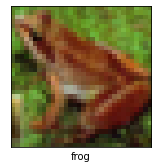

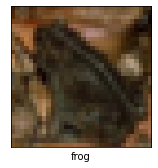

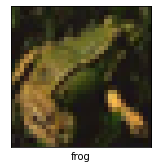

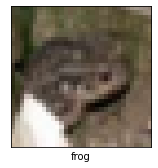

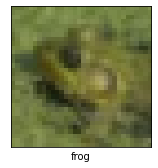

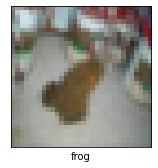

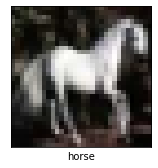

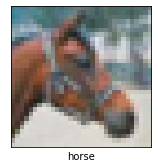

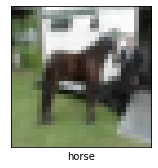

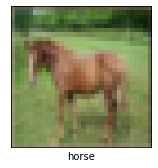

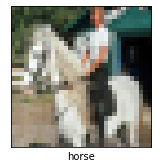

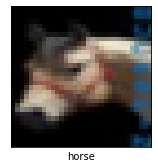

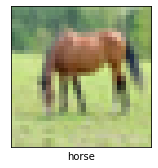

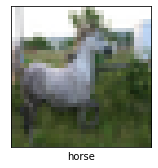

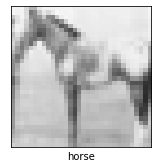

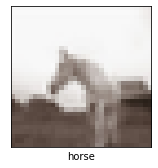

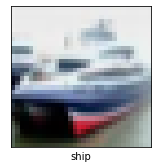

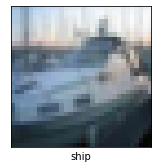

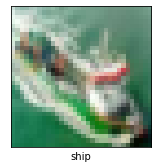

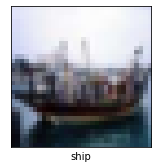

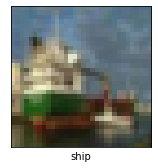

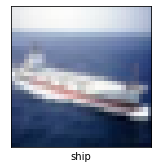

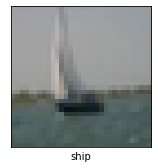

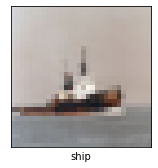

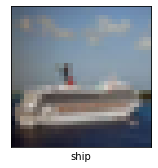

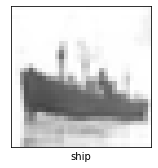

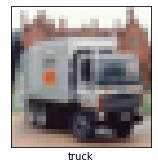

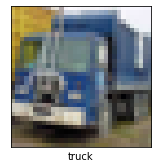

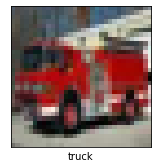

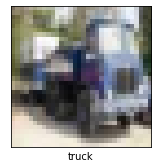

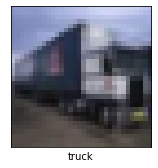

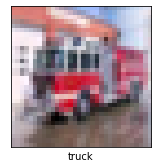

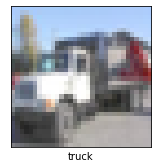

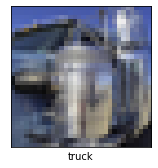

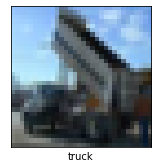

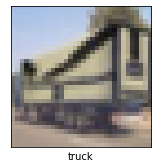

In [ ]:
#checking that the training examples match the labels chosen
for i in range(len(y_subsample)):
  show_image(x_subsample[i],y_subsample[i])

##visualizing data

In [ ]:
print('feature_shape',x_subsample[0].shape)
print('label_shape',y_train[0].shape)

feature_shape (32, 32, 3)
label_shape (1,)


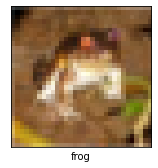

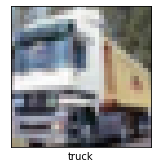

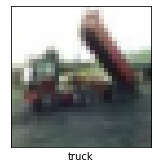

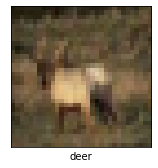

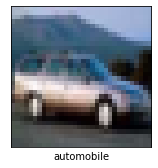

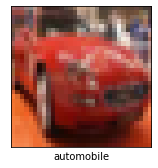

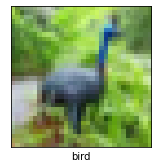

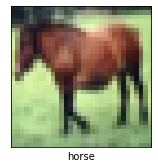

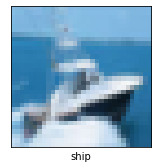

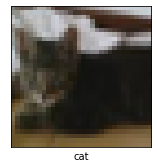

In [ ]:
#showing first 10 images 
for i in range(10):

  show_image(x_train[i],y_train[i])


#Models

####victim model

* Included Softmax layer at the end of victim_model so that we can measure the confidence of the model for each prediction, rather than just having the argmax value. This helps especially when defences are applied because even though the model misclassifies something, it may do so with a lesser level of confidence than it would had the defense not been applied. 

* For the classifier, we simply wrap the victim_model in a art.classifiers.KerasClassifier Wrapper so we can use it in all the attacks and defenses implemented by the art library. 

In [ ]:
#loading victim model
victim_model = keras.Sequential([keras.layers.Input(shape=(32,32,3)),
                                 hub.KerasLayer("https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1",
                                                input_shape=(32,32,3),
                                                output_shape=(10),name='Victim_Model'),
                                 keras.layers.Softmax()
                                 ])


In [ ]:
#building victim model to expect input shape of (batch size, image_height, image_width, image_depth/num_channels)
victim_model.build(input_shape=(100,32,32,3))

These metrics defined below are kind of irrelevant because we use accuracy_score and classification_report from sklearn.metrics, which includes f1 score, precision, recall, weighted average, and support. We can justify our reasoning for all of those. This link should help: https://towardsdatascience.com/understanding-data-science-classification-metrics-in-scikit-learn-in-python-3bc336865019

In [ ]:
metrics = ['mae','accuracy',]#IGNORE

In [ ]:
victim_model.compile(keras.optimizers.SGD(momentum=0.9,learning_rate=0.1),
                     loss=keras.losses.binary_crossentropy,
                     metrics = metrics)

Summary of model. A good visual to include in our report

In [ ]:
#model summary
victim_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Victim_Model (KerasLayer)    (None, 10)                7796426   
_________________________________________________________________
softmax_6 (Softmax)          (None, 10)                0         
Total params: 7,796,426
Trainable params: 0
Non-trainable params: 7,796,426
_________________________________________________________________


Also a good visual for the report 

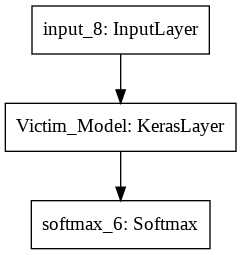

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(victim_model )

####Classifier

In [ ]:
classifier = art.classifiers.KerasClassifier(model = victim_model,use_logits=True)

#Attacks and Defenses

* All attacks and defenses are executed with the same attack function. 

####Attack Function

In [ ]:
def perform_attack(attack, defenses = [], x=x_subsample, y=y_subsample, targeted=False):
  """Performs attack and show results.
  If defenses are provided it performs each defense and
  shows results."""

  #attack classifier
  classifier = attack.classifier

  if targeted:
    y = targeted_labels

  #this routine is specific for adversarial patch examples
  if get_attack_name(attack)=='adversarial_patch':

    attack.generate(x)
    x_adversarial = adversarial_patch.apply_patch(x.copy(),0.3)
  
  
  else:
    x_adversarial = attack.generate(x,y)

  #metrics to measure 
  from sklearn.metrics import classification_report, accuracy_score
  from art.metrics import empirical_robustness

  
  #predictions without defense 
  attack_classifier_pred_originals =  np.argmax(classifier.predict(x),axis=1)
  attack_classifier_pred_adversarial =  np.argmax(classifier.predict(x_adversarial),axis=1)

  print('\nAttack effects on image\n==========================================================')

  #Showing visual impact
  for i in np.random.random_integers(0,99,3):
    print('\nBefore')
    show_image(x[i])
    get_confidence(classifier, np.expand_dims(x[i],0))

    print('\nAfter')
    show_image(x_adversarial[i])
    get_confidence(classifier, np.expand_dims(x_adversarial[i],0))

  print('\nPerformance w/ No Defense\n==========================================================================')
  print('performance on originals examples:\n','Accuracy:',accuracy_score(y_subsample, attack_classifier_pred_originals),'\n',classification_report(y_subsample, attack_classifier_pred_originals))

  print('performance on adversarial examples:\n','Accuracy:',accuracy_score(y_subsample, attack_classifier_pred_adversarial),'\n',classification_report(y_subsample, attack_classifier_pred_adversarial))

  print('\n======================================================================================')

  for defense in defenses:
    
    print('\nWith ',get_defense_name(defense),'defense applied\n===============================================================\n')

    #showing confidence before
    print('BEFORE DEFENSE')
    selected_images_idx = np.random.random_integers(0,99,1)

    for i in selected_images_idx:
      show_image(x[i])
      get_confidence(classifier, np.expand_dims(x[i],0))

    #mounting defense to classifier
    if get_defense_type(defense) == 'preprocessor':
      classifier.preprocessing_defences = [defense]
    elif get_defense_type(defense) == 'postprocessor':
      classifier.postprocessing_defences = [defense]

    #prediction with defenses 
    defense_classifier_pred_originals =  np.argmax(classifier.predict(x),axis=1)
    defense_classifier_pred_adversarial =  np.argmax(classifier.predict(x_adversarial),axis=1)

    #with defense applied
    print('\nPerformance on originals examples:\n','Accuracy:',accuracy_score(y_subsample,defense_classifier_pred_originals ),'\n',classification_report(y_subsample, defense_classifier_pred_originals))

    print('Performance on adversarial examples:\n','Accuracy:',accuracy_score(y_subsample, defense_classifier_pred_adversarial),'\n',classification_report(y_subsample, defense_classifier_pred_adversarial))

    print('\nWITH DEFENSE')
    #showing confidence after
    for i in selected_images_idx:
      show_image(x_adversarial[i])
      get_confidence(classifier, np.expand_dims(x_adversarial[i],0))

    #reset defence parameter to None
    classifier.preprocessing_defences = None
    classifier.postprocessing_defences = None

####Defenses

In [ ]:
from art.defences import PixelDefend, GaussianAugmentation, LabelSmoothing, ClassLabels, HighConfidence

defenses = [GaussianAugmentation(augmentation=False, sigma=.02, apply_predict=True), 
            LabelSmoothing(max_value=.9),
            #PixelDefend(pixel_cnn=classifier, clip_values=[0,1]), NOT WORKING 
            ClassLabels(),
            HighConfidence(cutoff=1.)]

####Target Labels

In [ ]:
targeted_labels = np.roll(y_subsample,20)

###ElasticNet Attack


Attack effects on image

Before


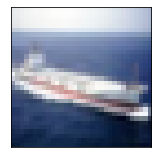

label: ship confidence: 0.99993134

After


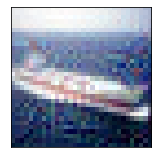

label: airplane confidence: 0.6339777

Before


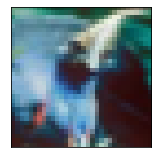

label: bird confidence: 0.9845754

After


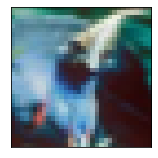

label: automobile confidence: 0.490049

Before


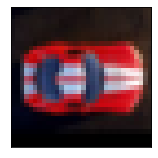

label: truck confidence: 0.95652986

After


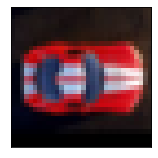

label: truck confidence: 0.95652986

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.06 
               precision    recall  f1-score   support

           0   

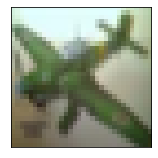

label: airplane confidence: 0.9999479

Performance on originals examples:
 Accuracy: 0.88 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.67      0.80      0.73        10
           4       0.82      0.90      0.86        10
           5       0.82      0.90      0.86        10
           6       0.82      0.90      0.86        10
           7       1.00      0.90      0.95        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.88       100
   macro avg       0.90      0.88      0.88       100
weighted avg       0.90      0.88      0.88       100

Performance on adversarial examples:
 Accuracy: 0.46 
               precision    recall  f1-score   support

           0       0.56      0.50      

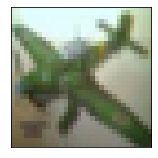

label: frog confidence: 0.81144917

With  label_smoothing defense applied

BEFORE DEFENSE


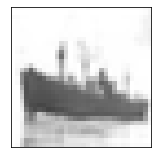

label: ship confidence: 0.9999896

Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.06 
               precision    recall  f1-score   support

           0       0.10      0.10      0.10

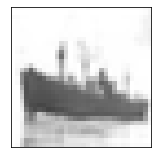

label: ship confidence: 0.9999896

With  class_labels defense applied

BEFORE DEFENSE


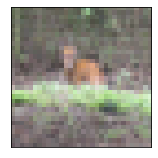

label: deer confidence: 0.9997074

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

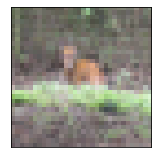

label: ship confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


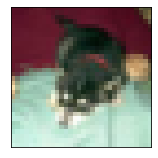

label: cat confidence: 0.929795

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18    

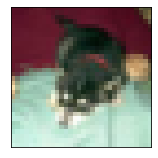

label: airplane confidence: 0.0

                                                 TARGETED ATTACK                                                


Attack effects on image

Before


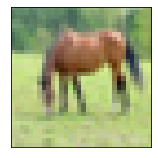

label: horse confidence: 0.99930847

After


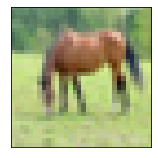

label: horse confidence: 0.99930847

Before


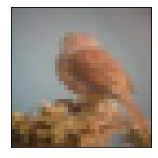

label: bird confidence: 0.99969757

After


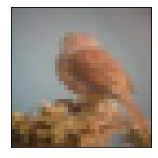

label: bird confidence: 0.99969757

Before


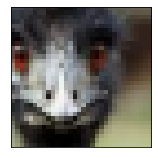

label: bird confidence: 0.99833494

After


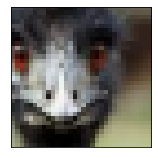

label: bird confidence: 0.99833494

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0     

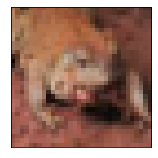

label: frog confidence: 0.999419

Performance on originals examples:
 Accuracy: 0.89 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       1.00      0.80      0.89        10
           2       0.82      0.90      0.86        10
           3       0.69      0.90      0.78        10
           4       1.00      0.90      0.95        10
           5       0.82      0.90      0.86        10
           6       0.90      0.90      0.90        10
           7       1.00      0.90      0.95        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.89       100
   macro avg       0.91      0.89      0.89       100
weighted avg       0.91      0.89      0.89       100

Performance on adversarial examples:
 Accuracy: 0.91 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82 

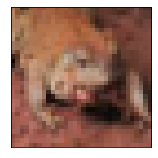

label: frog confidence: 0.9998406

With  label_smoothing defense applied

BEFORE DEFENSE


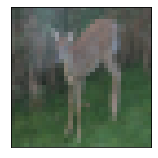

label: deer confidence: 0.9994235

Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00 

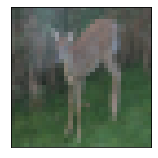

label: deer confidence: 0.9994235

With  class_labels defense applied

BEFORE DEFENSE


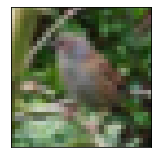

label: bird confidence: 0.9999609

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

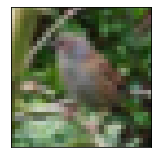

label: bird confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


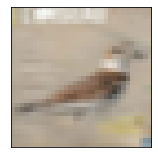

label: bird confidence: 0.9634955

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

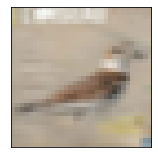

label: airplane confidence: 0.0


In [ ]:
from art.attacks import ElasticNet

elastic_net = ElasticNet(classifier=classifier,batch_size=32,max_iter=1,learning_rate=0.1,)
elastic_net_targeted = ElasticNet(classifier=classifier,batch_size=32,max_iter=5,learning_rate=0.1,targeted=True)

perform_attack(elastic_net, defenses)

print('\n==============================================================================================================')
print('                                                 TARGETED ATTACK                                                ')
print('==============================================================================================================\n')


perform_attack(elastic_net_targeted, defenses)

###DeepFool Attack


Attack effects on image

Before


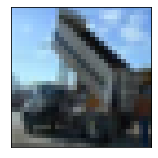

label: truck confidence: 0.9991824

After


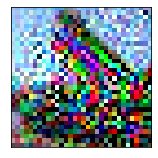

label: automobile confidence: 0.8744204

Before


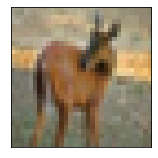

label: deer confidence: 0.98738796

After


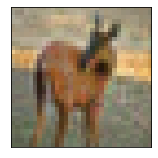

label: horse confidence: 0.99925417

Before


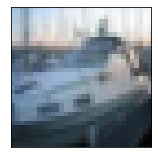

label: ship confidence: 0.9677206

After


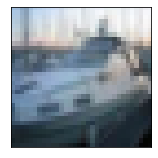

label: automobile confidence: 0.98765147

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.04 
               precision    recall  f1-score   support

          

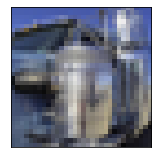

label: truck confidence: 0.46249518

Performance on originals examples:
 Accuracy: 0.89 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       1.00      0.80      0.89        10
           2       0.82      0.90      0.86        10
           3       0.73      0.80      0.76        10
           4       1.00      0.90      0.95        10
           5       0.83      1.00      0.91        10
           6       0.82      0.90      0.86        10
           7       1.00      0.90      0.95        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.89       100
   macro avg       0.90      0.89      0.89       100
weighted avg       0.90      0.89      0.89       100

Performance on adversarial examples:
 Accuracy: 0.08 
               precision    recall  f1-score   support

           0       0.00      0.00      0.

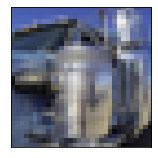

label: ship confidence: 0.6539244

With  label_smoothing defense applied

BEFORE DEFENSE


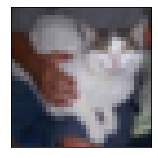

label: cat confidence: 0.99942493



Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.04 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.08

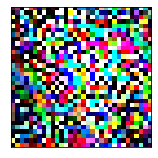

label: airplane confidence: 0.6727371

With  class_labels defense applied

BEFORE DEFENSE


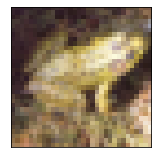

label: frog confidence: 0.9996778

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

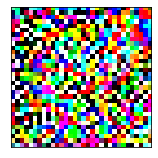

label: airplane confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


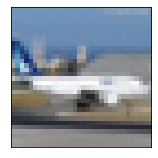

label: airplane confidence: 0.99923515

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      0.90      0

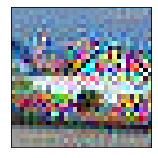

label: airplane confidence: 0.0


In [ ]:
from art.attacks import DeepFool

deep_fool = DeepFool(classifier=classifier,batch_size=32,max_iter=5)

perform_attack(deep_fool, defenses)

###NewtonFool Attack


Attack effects on image

Before


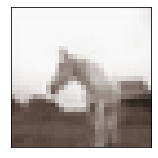

label: horse confidence: 0.9814115

After


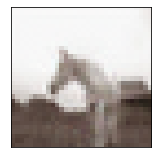

label: cat confidence: 0.99924123

Before


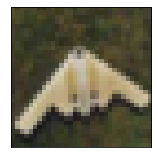

label: dog confidence: 0.83621454

After


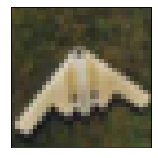

label: bird confidence: 0.45308334

Before


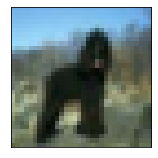

label: dog confidence: 0.9723006

After


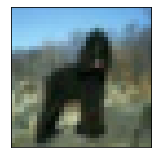

label: horse confidence: 0.7385976

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.51 
               precision    recall  f1-score   support

           0    

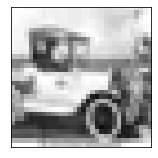

label: truck confidence: 0.5524687



Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       1.00      0.90      0.95        10
           2       0.90      0.90      0.90        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.83      1.00      0.91        10
           6       0.91      1.00      0.95        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.90      0.90      0.90        10

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.54 
               precision    recall  f1-score   support

           0       0.75      0.30      0.43        10
           1       0.67

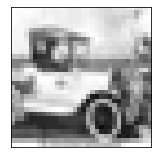

label: automobile confidence: 0.6142848

With  label_smoothing defense applied

BEFORE DEFENSE


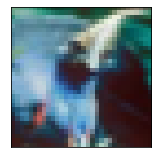

label: bird confidence: 0.9845754

Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.51 
               precision    recall  f1-score   support

           0       0.50      0.30      0.37

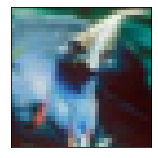

label: automobile confidence: 0.8658518

With  class_labels defense applied

BEFORE DEFENSE


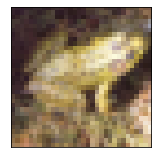

label: frog confidence: 0.9996778

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

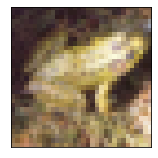

label: frog confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


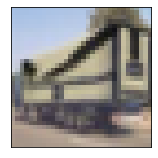

label: truck confidence: 0.99998987

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18

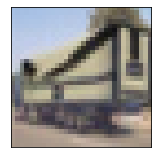

label: airplane confidence: 0.0


In [ ]:
from art.attacks import NewtonFool

newton_fool = NewtonFool(classifier=classifier,batch_size=32,max_iter=1)

perform_attack(newton_fool, defenses)

###FastGradient Method


Attack effects on image

Before


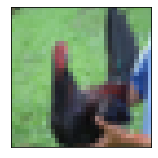

label: bird confidence: 0.9908826

After


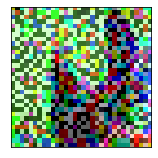

label: cat confidence: 0.9029583

Before


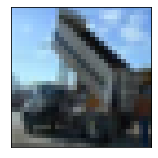

label: truck confidence: 0.9991824

After


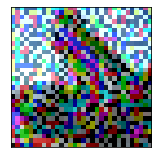

label: truck confidence: 0.96286225

Before


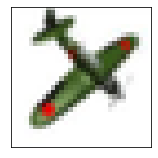

label: airplane confidence: 0.9989699

After


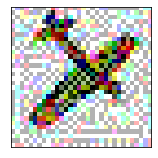

label: airplane confidence: 0.6024632

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.06 
               precision    recall  f1-score   support

           0 

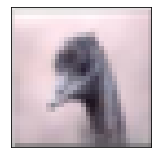

label: bird confidence: 0.89534706



Performance on originals examples:
 Accuracy: 0.9 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       1.00      0.90      0.95        10
           2       0.90      0.90      0.90        10
           3       0.73      0.80      0.76        10
           4       1.00      0.90      0.95        10
           5       0.77      1.00      0.87        10
           6       0.90      0.90      0.90        10
           7       1.00      0.90      0.95        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.90       100
   macro avg       0.91      0.90      0.90       100
weighted avg       0.91      0.90      0.90       100

Performance on adversarial examples:
 Accuracy: 0.05 
               precision    recall  f1-score   support

           0       0.09      0.10      0.10        10
           1       0.00 

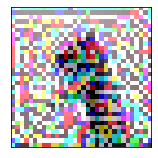

label: truck confidence: 0.9349607

With  label_smoothing defense applied

BEFORE DEFENSE


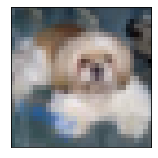

label: dog confidence: 0.9993723



Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.06 
               precision    recall  f1-score   support

           0       0.17      0.20      0.18        10
           1       0.00

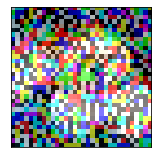

label: truck confidence: 0.89578223

With  class_labels defense applied

BEFORE DEFENSE


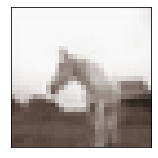

label: horse confidence: 0.9814115

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18 

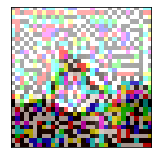

label: truck confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


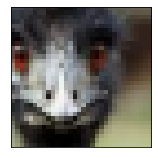

label: bird confidence: 0.99833494

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18 

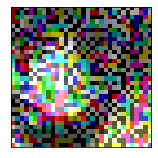

label: airplane confidence: 0.0

                                                 TARGETED ATTACK                                                


Attack effects on image

Before


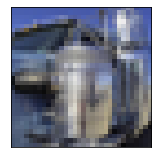

label: truck confidence: 0.46249518

After


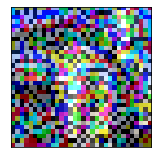

label: truck confidence: 0.47669643

Before


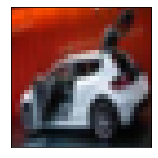

label: automobile confidence: 0.8471476

After


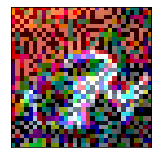

label: truck confidence: 0.87793857

Before


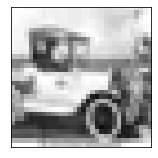

label: truck confidence: 0.5524687

After


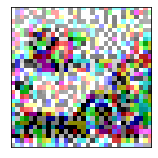

label: truck confidence: 0.8258944

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.15 
               precision    recall  f1-score   support

           0    

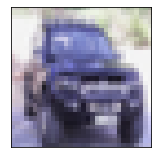

label: automobile confidence: 0.9991709



Performance on originals examples:
 Accuracy: 0.89 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       1.00      0.80      0.89        10
           2       0.80      0.80      0.80        10
           3       0.89      0.80      0.84        10
           4       0.90      0.90      0.90        10
           5       0.83      1.00      0.91        10
           6       0.91      1.00      0.95        10
           7       1.00      1.00      1.00        10
           8       0.91      1.00      0.95        10
           9       0.75      0.90      0.82        10

    accuracy                           0.89       100
   macro avg       0.90      0.89      0.89       100
weighted avg       0.90      0.89      0.89       100

Performance on adversarial examples:
 Accuracy: 0.16 
               precision    recall  f1-score   support

           0       0.14      0.20      0.17        10
           1       0.11

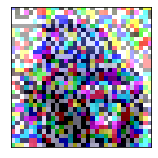

label: automobile confidence: 0.54117787

With  label_smoothing defense applied

BEFORE DEFENSE


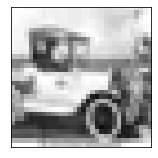

label: truck confidence: 0.5524687



Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.15 
               precision    recall  f1-score   support

           0       0.13      0.20      0.16        10
           1       0.11

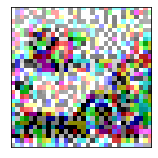

label: truck confidence: 0.8258944

With  class_labels defense applied

BEFORE DEFENSE


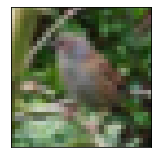

label: bird confidence: 0.9999609



Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00  

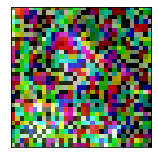

label: cat confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


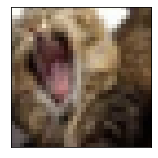

label: cat confidence: 0.9835259

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18   

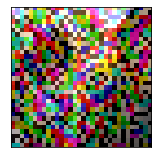

label: airplane confidence: 0.0


In [ ]:
from art.attacks import FastGradientMethod

fast_gradient_method = FastGradientMethod(classifier=classifier,batch_size=32)
fast_gradient_method_targeted = FastGradientMethod(classifier=classifier,batch_size=32,targeted=True)


perform_attack(fast_gradient_method, defenses)
print('\n==============================================================================================================')
print('                                                 TARGETED ATTACK                                                ')
print('==============================================================================================================\n')

perform_attack(fast_gradient_method_targeted, defenses)

###Threshold Attack

In [ ]:
!pip install cma

     |████████████████████████████████| 235kB 2.8MB/s eta 0:00:01



Attack effects on image

Before


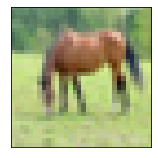

label: horse confidence: 0.99930847

After


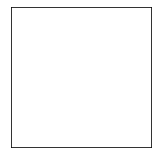

label: automobile confidence: 1.0

Before


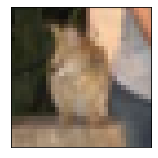

label: cat confidence: 0.91644955

After


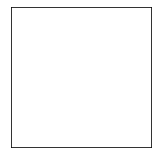

label: automobile confidence: 1.0

Before


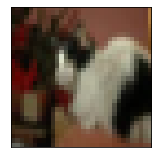

label: cat 

confidence: 0.99724954

After


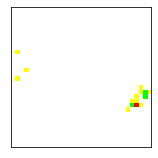

label: automobile confidence: 0.9970394

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0

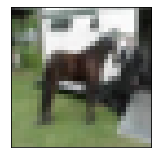

label: horse confidence: 0.99916875



Performance on originals examples:
 Accuracy: 0.91 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       1.00      0.90      0.95        10
           2       0.89      0.80      0.84        10
           3       0.75      0.90      0.82        10
           4       1.00      0.90      0.95        10
           5       0.91      1.00      0.95        10
           6       0.83      1.00      0.91        10
           7       0.90      0.90      0.90        10
           8       1.00      1.00      1.00        10
           9       0.91      1.00      0.95        10

    accuracy                           0.91       100
   macro avg       0.92      0.91      0.91       100
weighted avg       0.92      0.91      0.91       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.11 

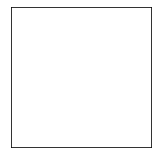

label: automobile confidence: 1.0

With  label_smoothing defense applied

BEFORE DEFENSE


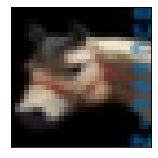

label: horse confidence: 0.9988024



Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.11 

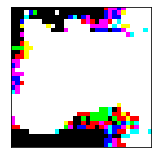

label: automobile confidence: 1.0

With  class_labels defense applied

BEFORE DEFENSE


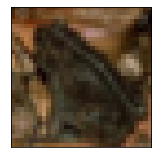

label: frog confidence: 0.9985379



Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00  

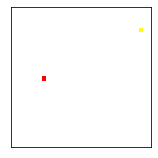

label: automobile confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


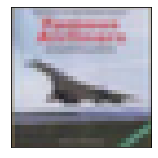

label: airplane confidence: 0.99929607

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.09 
               precision    recall  f1-score   support

           0       0.05      0.10      

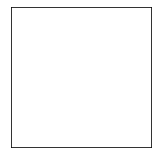

label: automobile confidence: 1.0

                                                 TARGETED ATTACK                                                


Attack effects on image

Before


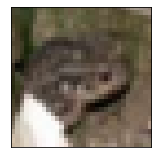

label: frog confidence: 0.99951124

After


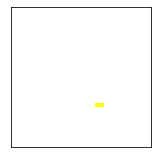

label: automobile confidence: 1.0

Before


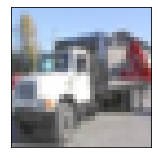

label: truck confidence: 0.9999957

After


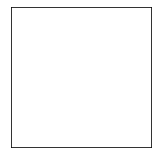

label: automobile confidence: 1.0

Before


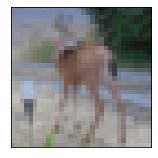

label: deer confidence: 0.9996112

After


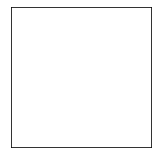

label: automobile confidence: 1.0

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0      

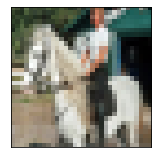

label: horse confidence: 0.9858166



Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       1.00      0.90      0.95        10
           2       0.90      0.90      0.90        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.91      1.00      0.95        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.91      1.00      0.95        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.11 

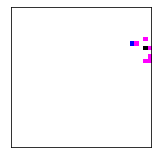

label: automobile confidence: 1.0

With  label_smoothing defense applied

BEFORE DEFENSE


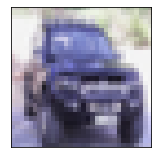

label: automobile confidence: 0.9991709



Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.11 

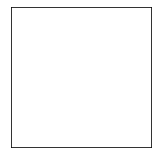

label: automobile confidence: 1.0

With  class_labels defense applied

BEFORE DEFENSE


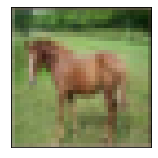

label: horse confidence: 0.9997098

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18 

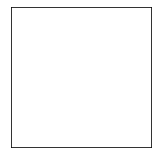

label: automobile confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


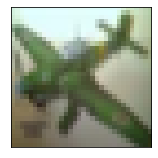

label: airplane confidence: 0.9999479



Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.09 
               precision    recall  f1-score   support

           0       0.05      0.10      0.07        10
           1       0.10 

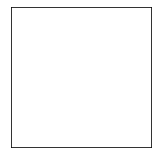

label: automobile confidence: 1.0


In [ ]:
from art.attacks import ThresholdAttack

threshold_attack = ThresholdAttack(classifier=classifier,th=.01,)
threshold_attack_targeted = ThresholdAttack(classifier=classifier,th=.01,targeted=True)


perform_attack(threshold_attack, defenses)
print('\n==============================================================================================================')
print('                                                 TARGETED ATTACK                                                ')
print('==============================================================================================================\n')

perform_attack(threshold_attack_targeted, defenses)

###Pixel Attack 


Attack effects on image

Before


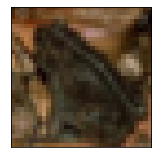

label: frog confidence: 0.9985379

After


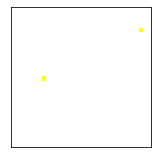

label: automobile confidence: 1.0

Before


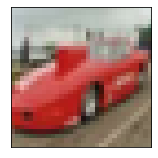

label: automobile confidence: 0.9995301

After


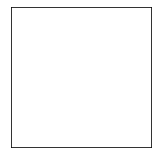

label: automobile confidence: 1.0

Before


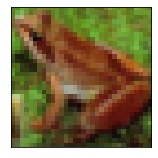

label: frog confidence: 0.9981748

After


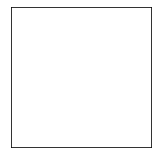

label: automobile confidence: 1.0

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.08 
               precision    recall  f1-score   support

           0     

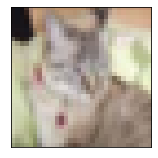

label: cat confidence: 0.99903774



Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       1.00      1.00      1.00        10
           2       0.90      0.90      0.90        10
           3       0.80      0.80      0.80        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.91      1.00      0.95        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.91      1.00      0.95        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.08 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.09

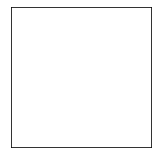

label: automobile confidence: 1.0

With  label_smoothing defense applied

BEFORE DEFENSE


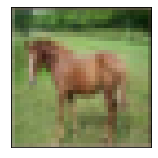

label: horse confidence: 0.9997098



Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.08 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.09

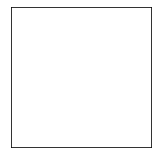

label: automobile confidence: 1.0

With  class_labels defense applied

BEFORE DEFENSE


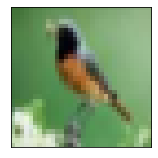

label: bird confidence: 0.999863

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100



Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100


WITH DEFENSE


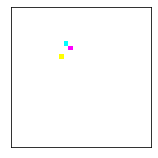

label: automobile confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


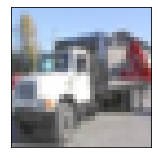

label: truck confidence: 0.9999957

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.09 
               precision    recall  f1-score   support

           0       0.05      0.10      0.07

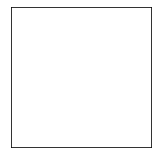

label: automobile confidence: 1.0

                                                 TARGETED ATTACK                                                


Attack effects on image

Before


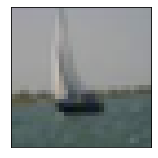

label: ship confidence: 0.99999976

After


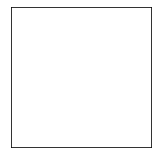

label: automobile confidence: 1.0

Before


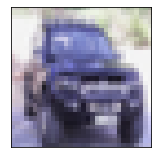

label: automobile confidence: 0.9991709

After


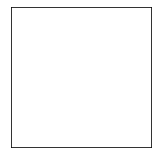

label: automobile confidence: 1.0

Before


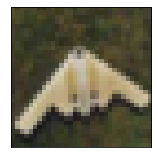

label: dog confidence: 0.83621454

After


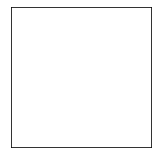

label: automobile confidence: 1.0

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0      

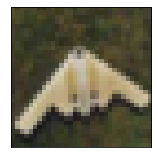

label: dog confidence: 0.83621454



Performance on originals examples:
 Accuracy: 0.91 
               precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       1.00      0.90      0.95        10
           2       0.90      0.90      0.90        10
           3       0.89      0.80      0.84        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.91      1.00      0.95        10
           7       1.00      1.00      1.00        10
           8       0.91      1.00      0.95        10
           9       0.82      0.90      0.86        10

    accuracy                           0.91       100
   macro avg       0.92      0.91      0.91       100
weighted avg       0.92      0.91      0.91       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.11 

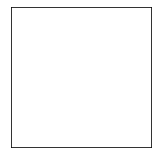

label: automobile confidence: 1.0

With  label_smoothing defense applied

BEFORE DEFENSE


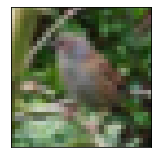

label: bird confidence: 0.9999609



Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.11 

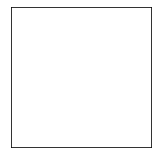

label: automobile confidence: 1.0

With  class_labels defense applied

BEFORE DEFENSE


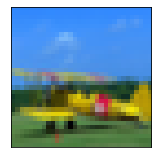

label: airplane confidence: 0.99998665

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0

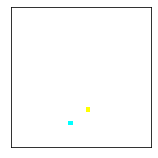

label: automobile confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


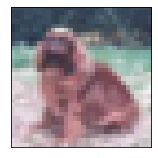

label: dog confidence: 0.9997242

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.06      0.10      0.07   

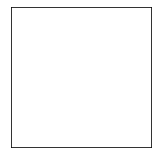

label: automobile confidence: 1.0


In [ ]:
from art.attacks import PixelAttack

pixel_attack = PixelAttack(classifier=classifier,th=1)
pixel_attack_targeted = PixelAttack(classifier=classifier,th=1,targeted=True)

perform_attack(pixel_attack, defenses)
print('\n==============================================================================================================')
print('                                                 TARGETED ATTACK                                                ')
print('==============================================================================================================\n')

perform_attack(pixel_attack_targeted, defenses)

###HopSkipJump Attack


Attack effects on image

Before


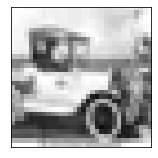

label: truck confidence: 0.5524687

After


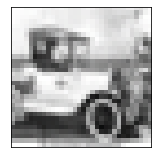

label: automobile confidence: 0.51465625

Before


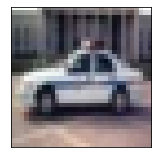

label: automobile confidence: 0.9999964

After


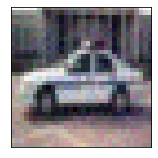

label: truck confidence: 0.9993513

Before


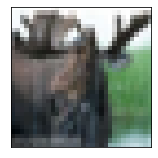

label: deer confidence: 0.9955531

After


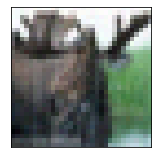

label: ship confidence: 0.9368203

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.07 
               precision    recall  f1-score   support

           0     

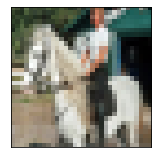

label: horse confidence: 0.9858166

Performance on originals examples:
 Accuracy: 0.91 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       1.00      0.90      0.95        10
           2       0.82      0.90      0.86        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.82      0.90      0.86        10
           6       0.91      1.00      0.95        10
           7       1.00      1.00      1.00        10
           8       0.91      1.00      0.95        10
           9       0.90      0.90      0.90        10

    accuracy                           0.91       100
   macro avg       0.92      0.91      0.91       100
weighted avg       0.92      0.91      0.91       100

Performance on adversarial examples:
 Accuracy: 0.14 
               precision    recall  f1-score   support

           0       0.00      0.00      0.0

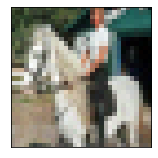

label: deer confidence: 0.6243024

With  label_smoothing defense applied

BEFORE DEFENSE


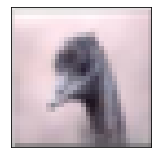

label: bird confidence: 0.89534706

Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.07 
               precision    recall  f1-score   support

           0       0.00      0.00      0.0

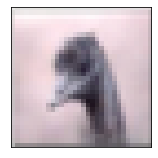

label: horse confidence: 0.7879952

With  class_labels defense applied

BEFORE DEFENSE


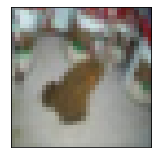

label: cat confidence: 0.9990382

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18   

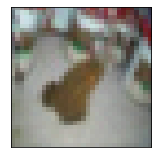

label: frog confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


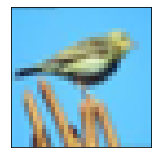

label: bird confidence: 0.9996295

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

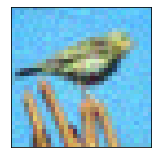

label: airplane confidence: 0.0

                                                 TARGETED ATTACK                                                




Attack effects on image

Before


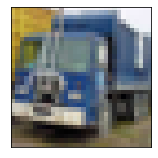

label: truck confidence: 0.9999912

After


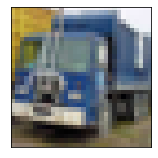

label: truck confidence: 0.9999912

Before


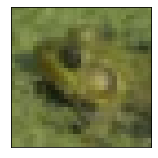

label: frog confidence: 0.99928695

After


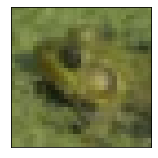

label: frog confidence: 0.99928695

Before


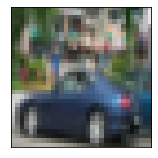

label: automobile confidence: 0.99186534

After


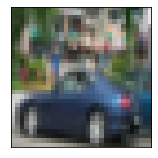

label: automobile confidence: 0.99186534

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.98 
               precision    recall  f1-score   support

          

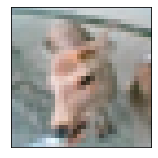

label: dog confidence: 0.7884026

Performance on originals examples:
 Accuracy: 0.91 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       1.00      0.90      0.95        10
           2       0.90      0.90      0.90        10
           3       0.73      0.80      0.76        10
           4       1.00      0.90      0.95        10
           5       0.83      1.00      0.91        10
           6       0.91      1.00      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.91       100
   macro avg       0.92      0.91      0.91       100
weighted avg       0.92      0.91      0.91       100

Performance on adversarial examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       1.00      0.80      0.89 

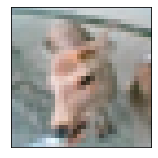

label: dog confidence: 0.81273836

With  label_smoothing defense applied

BEFORE DEFENSE


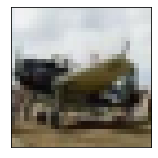

label: airplane confidence: 0.99334246

Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.98 
               precision    recall  f1-score   support

           0       1.00      1.00     

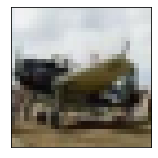

label: airplane confidence: 0.99334246

With  class_labels defense applied

BEFORE DEFENSE


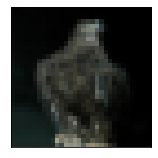

label: frog confidence: 0.9900087

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

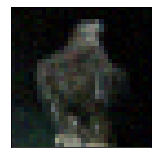

label: bird confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


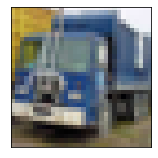

label: truck confidence: 0.9999912

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18 

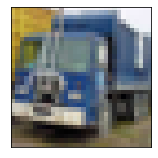

label: airplane confidence: 0.0


In [ ]:
from art.attacks import HopSkipJump

hop_skip_jump = HopSkipJump(classifier=classifier,max_iter=5,max_eval=1000)
hop_skip_jump_targeted = HopSkipJump(classifier=classifier,max_iter=5,max_eval=1000,targeted=True)


perform_attack(hop_skip_jump, defenses)
print('\n==============================================================================================================')
print('                                                 TARGETED ATTACK                                                ')
print('==============================================================================================================\n')

perform_attack(hop_skip_jump_targeted, defenses)


###Adversarial Patch


Attack effects on image

Before


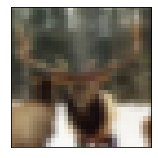

label: deer confidence: 0.99256814

After


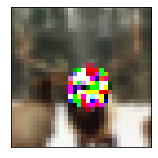

label: automobile confidence: 0.94902754

Before


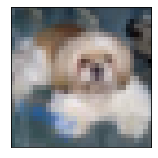

label: dog confidence: 0.9993723

After


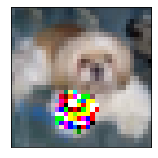

label: automobile confidence: 0.9917487

Before


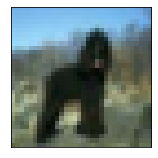

label: dog confidence: 0.9723006

After


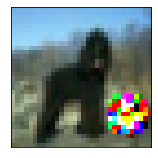

label: airplane confidence: 0.8680951

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.13 
               precision    recall  f1-score   support

           0 

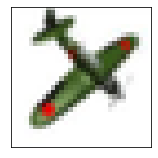

label: airplane confidence: 0.9989699



Performance on originals examples:
 Accuracy: 0.91 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       1.00      0.80      0.89        10
           2       0.90      0.90      0.90        10
           3       0.71      1.00      0.83        10
           4       1.00      0.90      0.95        10
           5       0.90      0.90      0.90        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.91       100
   macro avg       0.92      0.91      0.91       100
weighted avg       0.92      0.91      0.91       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.30      0.30      0.30        10
           1       0.10

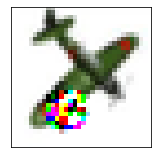

label: automobile confidence: 0.5002548

With  label_smoothing defense applied

BEFORE DEFENSE


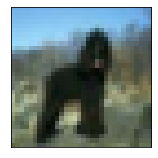

label: dog confidence: 0.9723006



Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.13 
               precision    recall  f1-score   support

           0       0.33      0.40      0.36        10
           1       0.10

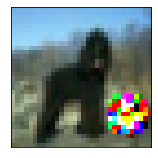

label: airplane confidence: 0.8680951

With  class_labels defense applied

BEFORE DEFENSE


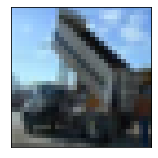

label: truck confidence: 0.9991824



Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00  

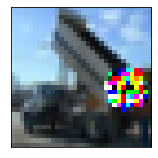

label: automobile confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


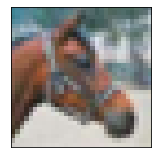

label: horse confidence: 0.99952924

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18

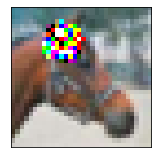

label: airplane confidence: 0.0


In [ ]:
from art.attacks import AdversarialPatch

adversarial_patch = AdversarialPatch(classifier=classifier,)

perform_attack(adversarial_patch, defenses)

###CarliniL2Method


Attack effects on image

Before


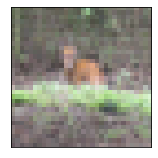

label: deer confidence: 0.9997074

After


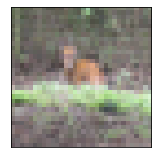

label: ship confidence: 0.5727589

Before


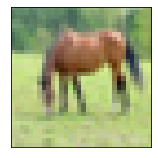

label: horse confidence: 0.99930847

After


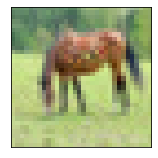

label: dog confidence: 0.8446779

Before


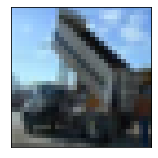

label: truck confidence: 0.9991824

After


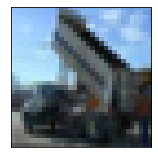

label: frog confidence: 0.9349401

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.28 
               precision    recall  f1-score   support

           0     

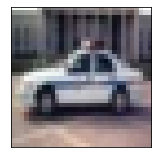

label: automobile confidence: 0.9999964

Performance on originals examples:
 Accuracy: 0.91 
               precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       1.00      0.80      0.89        10
           2       0.90      0.90      0.90        10
           3       0.89      0.80      0.84        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.91      1.00      0.95        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.77      1.00      0.87        10

    accuracy                           0.91       100
   macro avg       0.92      0.91      0.91       100
weighted avg       0.92      0.91      0.91       100

Performance on adversarial examples:
 Accuracy: 0.72 
               precision    recall  f1-score   support

           0       1.00      0.50    

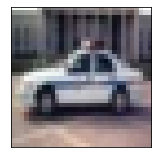

label: automobile confidence: 0.9999949

With  label_smoothing defense applied

BEFORE DEFENSE


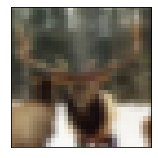

label: deer confidence: 0.99256814

Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.28 
               precision    recall  f1-score   support

           0       0.57      0.40      0.4

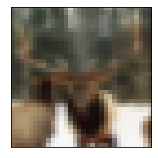

label: dog confidence: 0.6869324

With  class_labels defense applied

BEFORE DEFENSE


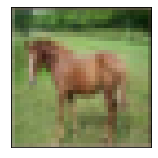

label: horse confidence: 0.9997098

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18 

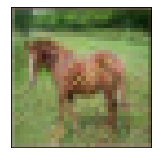

label: dog confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


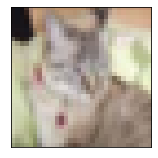

label: cat confidence: 0.99903774

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

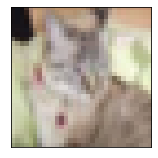

label: airplane confidence: 0.0

                                                 TARGETED ATTACK                                                


Attack effects on image

Before


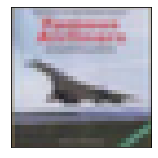

label: airplane confidence: 0.99929607

After


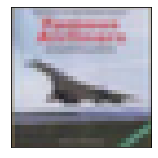

label: airplane confidence: 0.99929607

Before


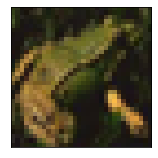

label: frog confidence: 0.9951139

After


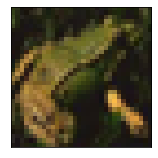

label: frog confidence: 0.9951139

Before


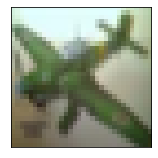

label: airplane confidence: 0.9999479

After


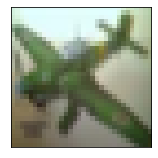

label: airplane confidence: 0.9999479

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0 

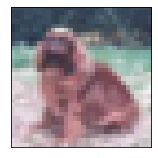

label: dog confidence: 0.9997242

Performance on originals examples:
 Accuracy: 0.94 
               precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       1.00      0.90      0.95        10
           2       0.90      0.90      0.90        10
           3       1.00      1.00      1.00        10
           4       1.00      0.90      0.95        10
           5       0.83      1.00      0.91        10
           6       0.91      1.00      0.95        10
           7       1.00      1.00      1.00        10
           8       0.91      1.00      0.95        10
           9       0.90      0.90      0.90        10

    accuracy                           0.94       100
   macro avg       0.95      0.94      0.94       100
weighted avg       0.95      0.94      0.94       100

Performance on adversarial examples:
 Accuracy: 0.93 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82 

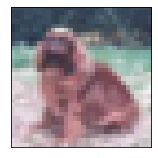

label: dog confidence: 0.9990476

With  label_smoothing defense applied

BEFORE DEFENSE


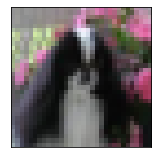

label: dog confidence: 0.9998599

Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00 

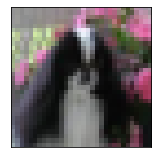

label: dog confidence: 0.9998599

With  class_labels defense applied

BEFORE DEFENSE


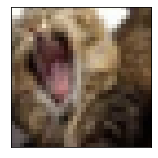

label: cat confidence: 0.9835259

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18   

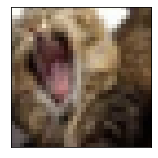

label: cat confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


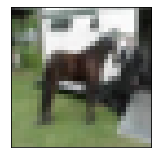

label: horse confidence: 0.99916875

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18

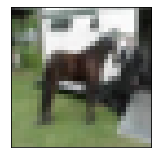

label: airplane confidence: 0.0


In [ ]:
from art.attacks import CarliniL2Method

carlini_l2 = CarliniL2Method(classifier=classifier,batch_size=32)
carlini_l2_targeted = CarliniL2Method(classifier=classifier,batch_size=32,targeted=True)

perform_attack(carlini_l2, defenses)
print('\n==============================================================================================================')
print('                                                 TARGETED ATTACK                                                ')
print('==============================================================================================================\n')


perform_attack(carlini_l2_targeted, defenses)

###Carlini L_Inf Method


Attack effects on image

Before


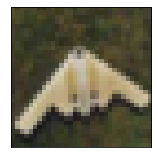

label: dog confidence: 0.83621454

After


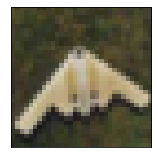

label: dog confidence: 0.83621454

Before


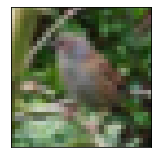

label: bird confidence: 0.9999609

After


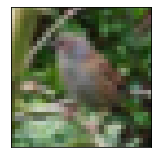

label: bird confidence: 0.9999609

Before


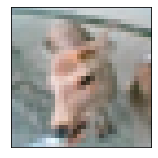

label: dog confidence: 0.7884026

After


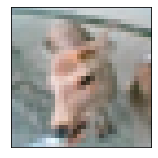

label: dog confidence: 0.7884026

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.27 
               precision    recall  f1-score   support

           0      

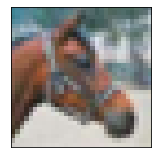

label: horse confidence: 0.99952924

Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       1.00      0.90      0.95        10
           2       0.82      0.90      0.86        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.82      0.90      0.86        10
           6       0.91      1.00      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      1.00      1.00        10
           9       0.91      1.00      0.95        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.52 
               precision    recall  f1-score   support

           0       0.83      0.50      0.

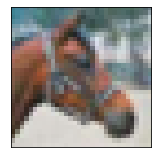

label: bird confidence: 0.93768626

With  label_smoothing defense applied

BEFORE DEFENSE


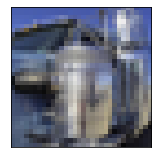

label: truck confidence: 0.46249518

Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.27 
               precision    recall  f1-score   support

           0       0.57      0.40      0.

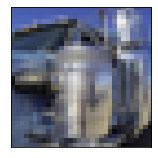

label: airplane confidence: 0.6801214

With  class_labels defense applied

BEFORE DEFENSE


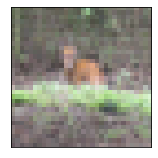

label: deer confidence: 0.9997074

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

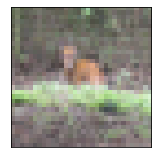

label: ship confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


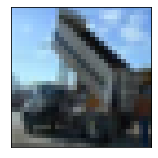

label: truck confidence: 0.9991824

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18 

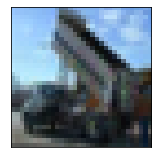

label: airplane confidence: 0.0

                                                 TARGETED ATTACK                                                


Attack effects on image

Before


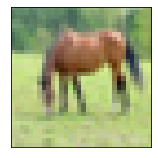

label: horse confidence: 0.99930847

After


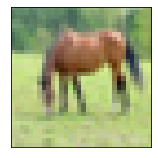

label: horse confidence: 0.99930847

Before


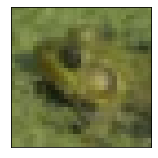

label: frog confidence: 0.99928695

After


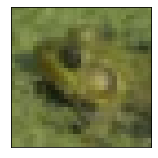

label: frog confidence: 0.99928695

Before


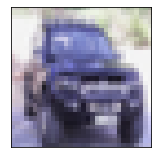

label: automobile confidence: 0.9991709

After


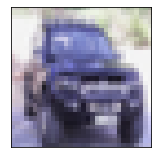

label: automobile confidence: 0.9991709

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           

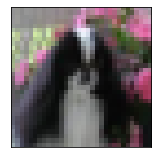

label: dog confidence: 0.9998599

Performance on originals examples:
 Accuracy: 0.88 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.89      0.80      0.84        10
           2       0.82      0.90      0.86        10
           3       0.78      0.70      0.74        10
           4       1.00      0.90      0.95        10
           5       0.82      0.90      0.86        10
           6       0.83      1.00      0.91        10
           7       1.00      1.00      1.00        10
           8       0.91      1.00      0.95        10
           9       0.82      0.90      0.86        10

    accuracy                           0.88       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.88      0.88       100

Performance on adversarial examples:
 Accuracy: 0.93 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82 

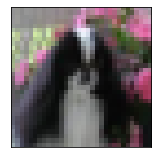

label: dog confidence: 0.99922705

With  label_smoothing defense applied

BEFORE DEFENSE


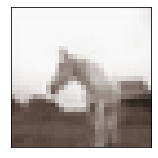

label: horse confidence: 0.9814115

Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.0

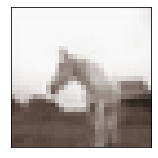

label: horse confidence: 0.9814115

With  class_labels defense applied

BEFORE DEFENSE


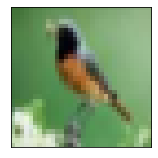

label: bird confidence: 0.999863

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18   

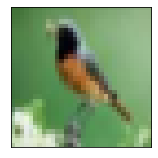

label: bird confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


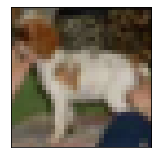

label: dog confidence: 0.9952614

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18   

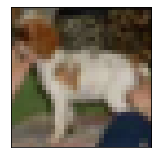

label: airplane confidence: 0.0


In [ ]:
from art.attacks import CarliniLInfMethod

carlini_linf = CarliniLInfMethod(classifier=classifier,batch_size=50)
carlini_linf_targeted = CarliniLInfMethod(classifier=classifier,batch_size=50,targeted=True)


perform_attack(carlini_linf, defenses)
print('\n==============================================================================================================')
print('                                                 TARGETED ATTACK                                                ')
print('==============================================================================================================\n')


perform_attack(carlini_linf_targeted, defenses)

###Basic Iterative Method


Attack effects on image

Before


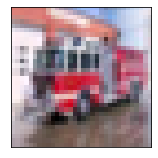

label: truck confidence: 0.9999701

After


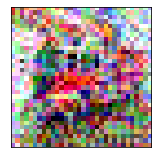

label: frog confidence: 0.9999964

Before


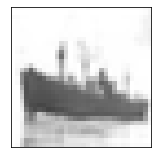

label: ship confidence: 0.9999896

After


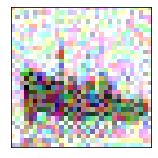

label: cat confidence: 1.0

Before


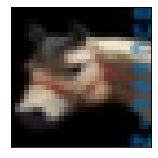

label: horse confidence: 0.9988024

After


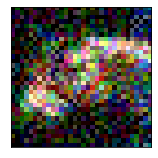

label: bird confidence: 0.9999999

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0      

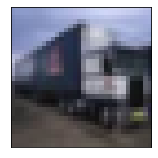

label: truck confidence: 0.99999213



Performance on originals examples:
 Accuracy: 0.9 
               precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       1.00      0.80      0.89        10
           2       0.90      0.90      0.90        10
           3       0.80      0.80      0.80        10
           4       1.00      0.90      0.95        10
           5       0.82      0.90      0.86        10
           6       0.91      1.00      0.95        10
           7       1.00      1.00      1.00        10
           8       0.91      1.00      0.95        10
           9       0.75      0.90      0.82        10

    accuracy                           0.90       100
   macro avg       0.91      0.90      0.90       100
weighted avg       0.91      0.90      0.90       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      10.0
           1       0.00  

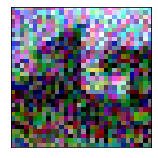

label: frog confidence: 1.0

With  label_smoothing defense applied

BEFORE DEFENSE


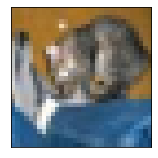

label: cat confidence: 0.9999783



Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      10.0
           1       0.00 

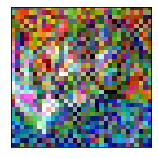

label: bird confidence: 0.99999976

With  class_labels defense applied

BEFORE DEFENSE


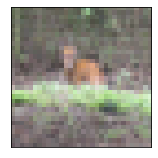

label: deer confidence: 0.9997074

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00  

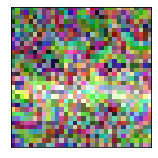

label: frog confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


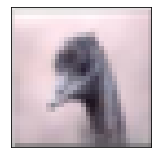

label: bird confidence: 0.89534706



Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.04 
               precision    recall  f1-score   support

           0       0.09      0.40      0.15        10
           1       0.00 

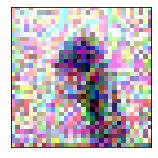

label: airplane confidence: 0.0

                                                 TARGETED ATTACK                                                


Attack effects on image

Before


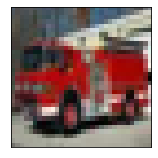

label: truck confidence: 0.9994281

After


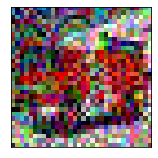

label: truck confidence: 0.9999995

Before


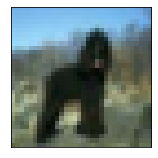

label: dog confidence: 0.9723006

After


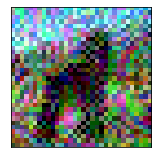

label: dog confidence: 0.99999976

Before


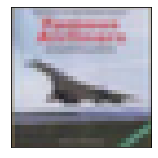

label: airplane confidence: 0.99929607

After


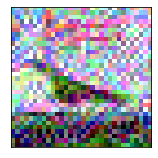

label: airplane confidence: 1.0

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       

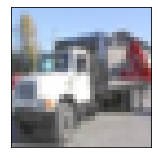

label: truck confidence: 0.9999957

Performance on originals examples:
 Accuracy: 0.91 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       1.00      1.00      1.00        10
           2       0.80      0.80      0.80        10
           3       0.75      0.90      0.82        10
           4       1.00      0.90      0.95        10
           5       0.90      0.90      0.90        10
           6       0.90      0.90      0.90        10
           7       0.91      1.00      0.95        10
           8       1.00      1.00      1.00        10
           9       0.91      1.00      0.95        10

    accuracy                           0.91       100
   macro avg       0.92      0.91      0.91       100
weighted avg       0.92      0.91      0.91       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.0

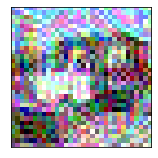

label: truck confidence: 1.0

With  label_smoothing defense applied

BEFORE DEFENSE


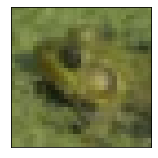

label: frog confidence: 0.99928695

Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.0

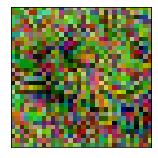

label: frog confidence: 0.9999999

With  class_labels defense applied

BEFORE DEFENSE


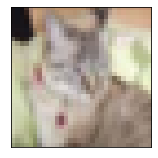

label: cat confidence: 0.99903774



Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00  

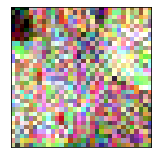

label: cat confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


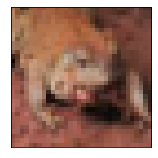

label: frog confidence: 0.999419

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.53 
               precision    recall  f1-score   support

           0       0.18      1.00      0.30  

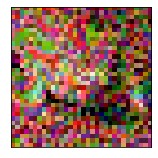

label: frog confidence: 1.0


In [ ]:
from art.attacks import BasicIterativeMethod

basic_iterative = BasicIterativeMethod(classifier=classifier,batch_size=32)
basic_iterative_targeted = BasicIterativeMethod(classifier=classifier,batch_size=32,targeted=True)

perform_attack(basic_iterative, defenses)
print('\n==============================================================================================================')
print('                                                 TARGETED ATTACK                                                ')
print('==============================================================================================================\n')

perform_attack(basic_iterative_targeted, defenses)

###Projected Gradient Descent


Attack effects on image

Before


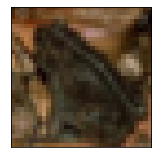

label: frog confidence: 0.9985379

After


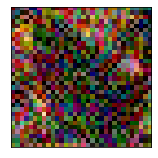

label: bird confidence: 1.0

Before


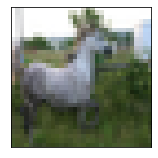

label: horse confidence: 0.99969697

After


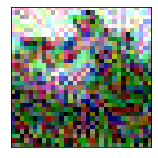

label: frog confidence: 0.99999976

Before


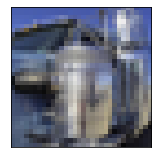

label: truck confidence: 0.46249518

After


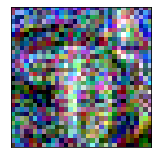

label: bird confidence: 1.0

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00 

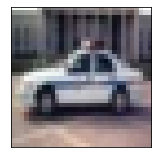

label: automobile confidence: 0.9999964



Performance on originals examples:
 Accuracy: 0.93 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       1.00      1.00      1.00        10
           2       0.90      0.90      0.90        10
           3       0.90      0.90      0.90        10
           4       1.00      0.90      0.95        10
           5       0.77      1.00      0.87        10
           6       0.91      1.00      0.95        10
           7       1.00      1.00      1.00        10
           8       0.91      1.00      0.95        10
           9       1.00      0.90      0.95        10

    accuracy                           0.93       100
   macro avg       0.94      0.93      0.93       100
weighted avg       0.94      0.93      0.93       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      10.0
           1       0.00 

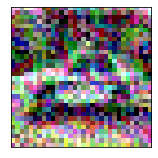

label: frog confidence: 1.0

With  label_smoothing defense applied

BEFORE DEFENSE


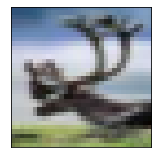

label: deer confidence: 0.9994717



Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      10.0
           1       0.00 

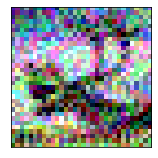

label: frog confidence: 0.99999213

With  class_labels defense applied

BEFORE DEFENSE


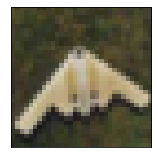

label: dog confidence: 0.83621454



Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.10  

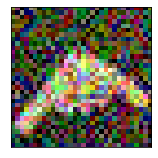

label: bird confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


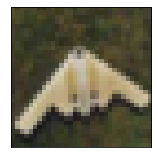

label: dog confidence: 0.83621454



Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.03 
               precision    recall  f1-score   support

           0       0.07      0.30      0.11        10
           1       0.00 

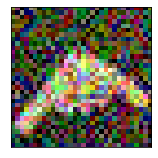

label: bird confidence: 1.0

                                                 TARGETED ATTACK                                                


Attack effects on image

Before


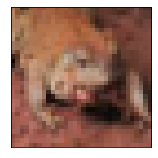

label: frog confidence: 0.999419

After


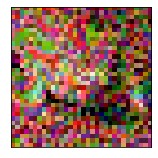

label: frog confidence: 1.0

Before


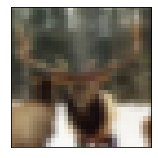

label: deer confidence: 0.99256814

After


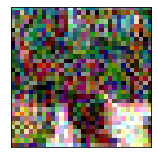

label: deer confidence: 0.99999964

Before


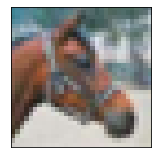

label: horse confidence: 0.99952924

After


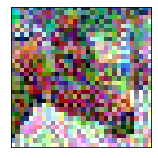

label: horse confidence: 0.9999912

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0    

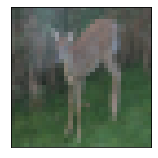

label: deer confidence: 0.9994235



Performance on originals examples:
 Accuracy: 0.88 
               precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       1.00      0.80      0.89        10
           2       0.80      0.80      0.80        10
           3       0.80      0.80      0.80        10
           4       1.00      0.90      0.95        10
           5       0.82      0.90      0.86        10
           6       0.91      1.00      0.95        10
           7       0.91      1.00      0.95        10
           8       1.00      1.00      1.00        10
           9       0.75      0.90      0.82        10

    accuracy                           0.88       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.88      0.88       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00

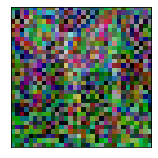

label: deer confidence: 0.99999845

With  label_smoothing defense applied

BEFORE DEFENSE


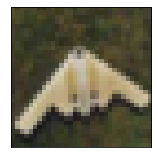

label: dog confidence: 0.83621454



Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00

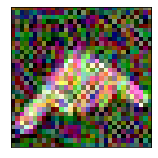

label: airplane confidence: 1.0

With  class_labels defense applied

BEFORE DEFENSE


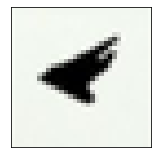

label: airplane confidence: 0.9998981



Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00  

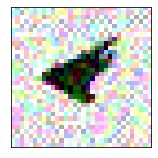

label: airplane confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


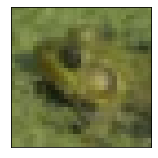

label: frog confidence: 0.99928695



Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.55 
               precision    recall  f1-score   support

           0       0.18      1.00      0.31        10
           1       1.00 

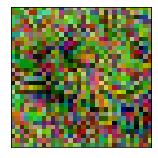

label: airplane confidence: 0.0


In [ ]:
from art.attacks import ProjectedGradientDescent

projected_gradient_descent = ProjectedGradientDescent(classifier=classifier,batch_size=32)
projected_gradient_descent_targeted = ProjectedGradientDescent(classifier=classifier,batch_size=32,targeted=True)

perform_attack(projected_gradient_descent, defenses)
print('\n==============================================================================================================')
print('                                                 TARGETED ATTACK                                                ')
print('==============================================================================================================\n')

perform_attack(projected_gradient_descent_targeted, defenses)

###Jacobian Saliency Map Method


Attack effects on image

Before


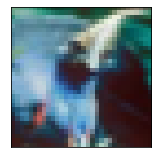

label: bird confidence: 0.9845754

After


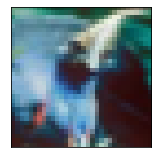

label: bird confidence: 0.9845754

Before


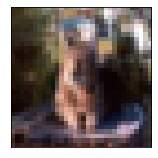

label: cat confidence: 0.9938543

After


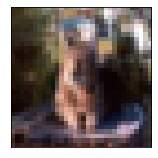

label: cat confidence: 0.9938543

Before


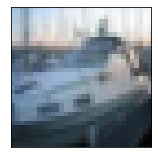

label: ship confidence: 0.9677206

After


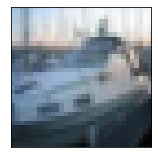

label: ship confidence: 0.9677206

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.93 
               precision    recall  f1-score   support

           0     

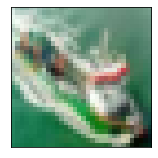

label: ship confidence: 0.9896624

Performance on originals examples:
 Accuracy: 0.94 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       1.00      1.00      1.00        10
           2       0.90      0.90      0.90        10
           3       0.90      0.90      0.90        10
           4       1.00      0.90      0.95        10
           5       0.77      1.00      0.87        10
           6       0.91      1.00      0.95        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10

    accuracy                           0.94       100
   macro avg       0.95      0.94      0.94       100
weighted avg       0.95      0.94      0.94       100

Performance on adversarial examples:
 Accuracy: 0.9 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82 

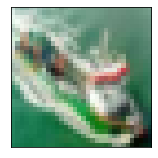

label: ship confidence: 0.9941678

With  label_smoothing defense applied

BEFORE DEFENSE


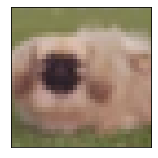

label: dog confidence: 0.99993193

Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.93 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95

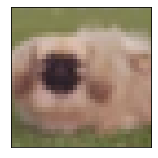

label: dog confidence: 0.99993193

With  class_labels defense applied

BEFORE DEFENSE


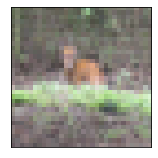

label: deer confidence: 0.9997074

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

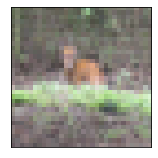

label: deer confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


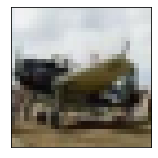

label: airplane confidence: 0.99334246

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0

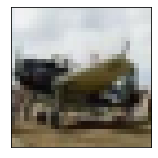

label: airplane confidence: 0.0


In [ ]:
from art.attacks import SaliencyMapMethod

saliency_map = SaliencyMapMethod(classifier=classifier)

perform_attack(saliency_map, defenses)

###Spatial Transformations Attack


Attack effects on image

Before


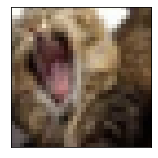

label: cat confidence: 0.9835259

After


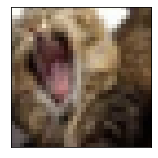

label: cat confidence: 0.9835259

Before


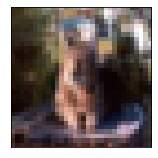

label: cat confidence: 0.9938543

After


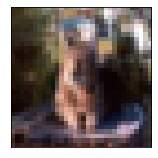

label: cat confidence: 0.9938543

Before


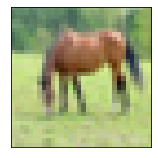

label: horse confidence: 0.99930847

After


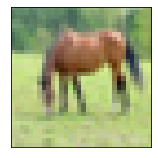

label: horse confidence: 0.99930847

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0   

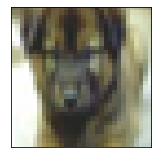

label: dog confidence: 0.9943288

Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       1.00      0.90      0.95        10
           2       0.90      0.90      0.90        10
           3       0.75      0.90      0.82        10
           4       1.00      0.90      0.95        10
           5       0.82      0.90      0.86        10
           6       0.91      1.00      0.95        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.91      1.00      0.95        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.91 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82 

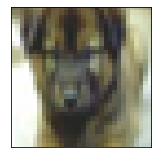

label: dog confidence: 0.99824786

With  label_smoothing defense applied

BEFORE DEFENSE


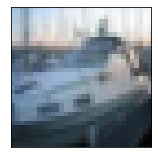

label: ship confidence: 0.9677206

Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95

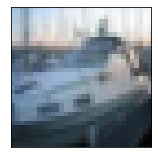

label: ship confidence: 0.9677206

With  class_labels defense applied

BEFORE DEFENSE


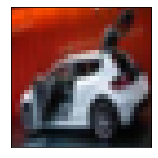

label: automobile confidence: 0.8471476

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      

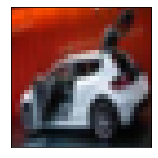

label: automobile confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


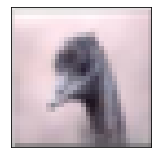

label: bird confidence: 0.89534706

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18 

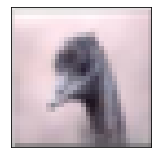

label: airplane confidence: 0.0


In [ ]:
from art.attacks import SpatialTransformation

spatial_transformation = SpatialTransformation(classifier=classifier)

perform_attack(spatial_transformation, defenses)

###Universal Perturbation Attack

art.attacks.evasion.deepfool.DeepFool

Attack effects on image

Before


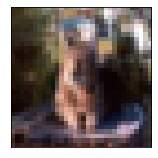

label: cat confidence: 0.9938543

After


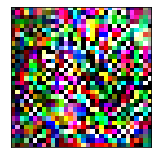

label: cat confidence: 0.60292155

Before


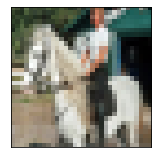

label: horse confidence: 0.9858166

After


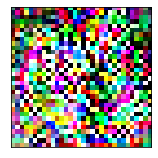

label: airplane confidence: 0.5323942

Before


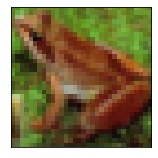

label: frog confidence: 0.9981748

After


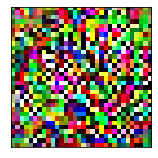

label: cat confidence: 0.6086848

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0      

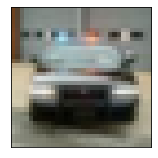

label: automobile confidence: 0.99904567



Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       1.00      0.90      0.95        10
           2       0.82      0.90      0.86        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.82      0.90      0.86        10
           6       0.91      1.00      0.95        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.91      1.00      0.95        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.12      0.20      0.15        10
           1       0.00

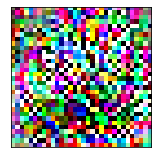

label: cat confidence: 0.54010075

With  label_smoothing defense applied

BEFORE DEFENSE


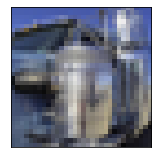

label: truck confidence: 0.46249518



Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.12      0.20      0.15        10
           1       0.00

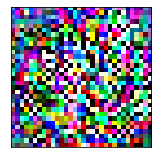

label: cat confidence: 0.4973433

With  class_labels defense applied

BEFORE DEFENSE


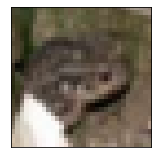

label: frog confidence: 0.99951124

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18 

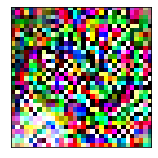

label: cat confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


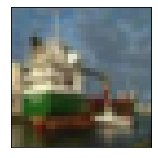

label: ship confidence: 0.99911875

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18 

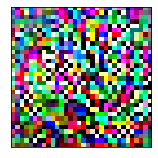

label: airplane confidence: 0.0


In [ ]:
from art.attacks import UniversalPerturbation

universal_perturbation = UniversalPerturbation(classifier=classifier)

perform_attack(universal_perturbation, defenses)

###Zeroth Order Optimization Attack


Attack effects on image

Before


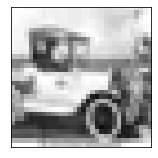

label: truck confidence: 0.5524687

After


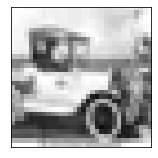

label: truck confidence: 0.5524687

Before


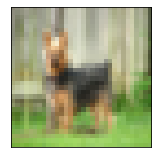

label: dog confidence: 0.9832055

After


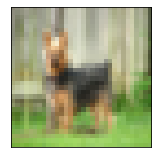

label: dog confidence: 0.9832055

Before


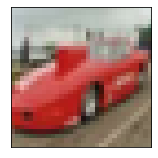

label: automobile confidence: 0.9995301

After


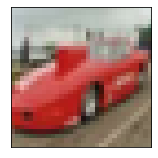

label: automobile confidence: 0.9995301

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.91 
               precision    recall  f1-score   support

           

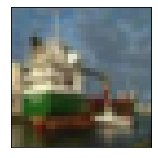

label: ship confidence: 0.99911875

Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       1.00      0.90      0.95        10
           2       0.90      0.90      0.90        10
           3       0.90      0.90      0.90        10
           4       1.00      0.90      0.95        10
           5       0.77      1.00      0.87        10
           6       0.91      1.00      0.95        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.90      0.90      0.90        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.87 
               precision    recall  f1-score   support

           0       1.00      0.70      0.8

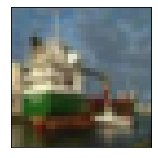

label: ship confidence: 0.96500725

With  label_smoothing defense applied

BEFORE DEFENSE


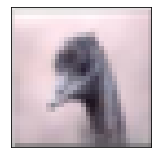

label: bird confidence: 0.89534706

Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.91 
               precision    recall  f1-score   support

           0       0.90      0.90      0.9

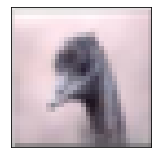

label: bird confidence: 0.89534706

With  class_labels defense applied

BEFORE DEFENSE


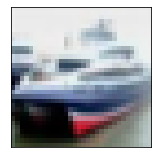

label: ship confidence: 0.9827665

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

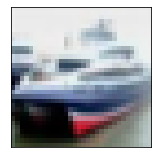

label: ship confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


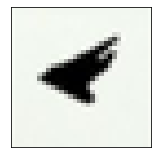

label: airplane confidence: 0.9998981

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.

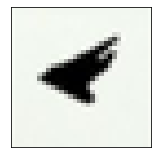

label: airplane confidence: 0.0

                                                 TARGETED ATTACK                                                


Attack effects on image

Before


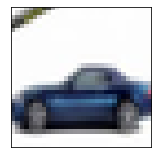

label: automobile confidence: 0.99997616

After


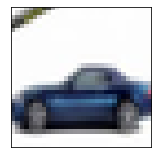

label: automobile confidence: 0.99997616

Before


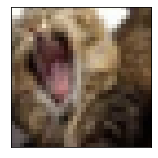

label: cat confidence: 0.9835259

After


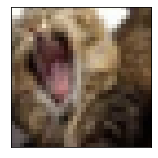

label: cat confidence: 0.9835259

Before


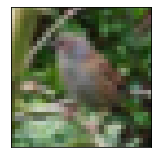

label: bird confidence: 0.9999609

After


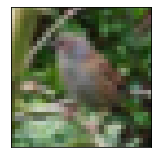

label: bird confidence: 0.9999609

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.93 
               precision    recall  f1-score   support

           0     

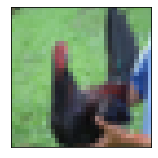

label: bird confidence: 0.9908826

Performance on originals examples:
 Accuracy: 0.9 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       1.00      0.90      0.95        10
           2       0.82      0.90      0.86        10
           3       0.80      0.80      0.80        10
           4       1.00      0.90      0.95        10
           5       0.83      1.00      0.91        10
           6       0.82      0.90      0.86        10
           7       1.00      1.00      1.00        10
           8       0.91      1.00      0.95        10
           9       0.90      0.90      0.90        10

    accuracy                           0.90       100
   macro avg       0.91      0.90      0.90       100
weighted avg       0.91      0.90      0.90       100

Performance on adversarial examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82 

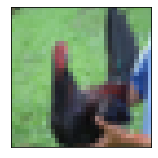

label: bird confidence: 0.96452403

With  label_smoothing defense applied

BEFORE DEFENSE


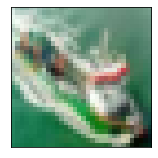

label: ship confidence: 0.9896624

Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.93 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95

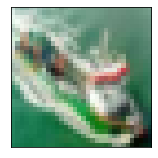

label: ship confidence: 0.9896624

With  class_labels defense applied

BEFORE DEFENSE


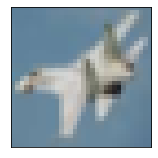

label: airplane confidence: 0.9999877

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.

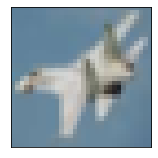

label: airplane confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


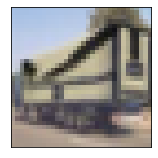

label: truck confidence: 0.99998987

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18

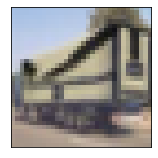

label: airplane confidence: 0.0


In [ ]:
from art.attacks import ZooAttack

zoo_attack = ZooAttack(classifier=classifier, max_iter = 1, binary_search_steps=5)
zoo_attack_targeted = ZooAttack(classifier=classifier, max_iter = 1, binary_search_steps=5,targeted=True)


perform_attack(zoo_attack, defenses)
print('\n==============================================================================================================')
print('                                                 TARGETED ATTACK                                                ')
print('==============================================================================================================\n')

perform_attack(zoo_attack_targeted, defenses)

###Virtual Adversarial Method

In [ ]:
va_classifier = art.classifiers.KerasClassifier(model = victim_model, clip_values=[0,1])


Attack effects on image

Before


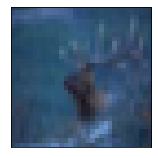

label: deer confidence: 0.99842936

After


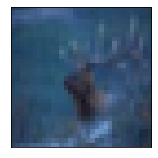

label: deer confidence: 0.9995183

Before


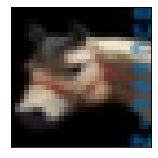

label: horse confidence: 0.9988024

After


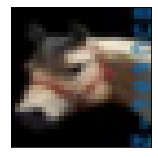

label: horse confidence: 0.9996371

Before


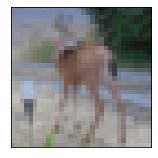

label: deer confidence: 0.9996112

After


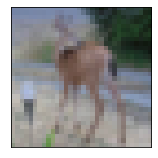

label: deer confidence: 0.99972516

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

performance on adversarial examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0    

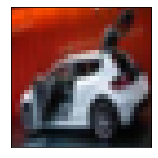

label: automobile confidence: 0.8471476

Performance on originals examples:
 Accuracy: 0.9 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       1.00      0.90      0.95        10
           2       0.90      0.90      0.90        10
           3       0.80      0.80      0.80        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.91      1.00      0.95        10
           7       1.00      1.00      1.00        10
           8       0.91      1.00      0.95        10
           9       0.82      0.90      0.86        10

    accuracy                           0.90       100
   macro avg       0.91      0.90      0.90       100
weighted avg       0.91      0.90      0.90       100

Performance on adversarial examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.70     

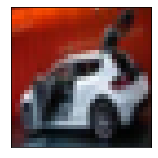

label: automobile confidence: 0.9402506

With  label_smoothing defense applied

BEFORE DEFENSE


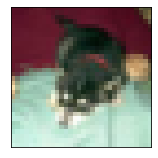

label: cat confidence: 0.929795

Performance on originals examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.80      0.89        10
           2       1.00      0.90      0.95        10
           3       0.82      0.90      0.86        10
           4       1.00      0.90      0.95        10
           5       0.75      0.90      0.82        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Performance on adversarial examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95  

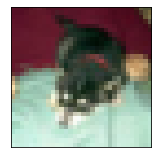

label: cat confidence: 0.7544776

With  class_labels defense applied

BEFORE DEFENSE


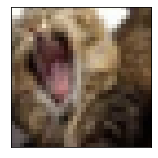

label: cat confidence: 0.9835259

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18   

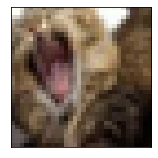

label: cat confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


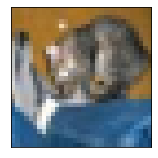

label: cat confidence: 0.9999783

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18   

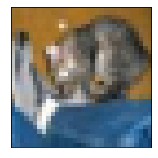

label: airplane confidence: 0.0


In [ ]:
from art.attacks import VirtualAdversarialMethod

virtual_adversarial = VirtualAdversarialMethod(classifier=va_classifier, batch_size=32)

perform_attack(virtual_adversarial, defenses)

###High Confidence Low Uncertainty Attack*(errors)

In [ ]:
from art.attacks import HighConfidenceLowUncertainty

hclu_attack = HighConfidenceLowUncertainty(classifier=classifier)

perform_attack(hclu_attack, defenses)

TypeError: ignored

###Decision Tree Attack*(errors: needs decision tree classifier)

In [ ]:
from art.attacks import DecisionTreeAttack

decision_tree_attack = DecisionTreeAttack(classifier=classifier)

perform_attack(decision_tree_attack, defenses)

#ERRORS WITH PIXELDEFEND and Other Concerns

(If you want to execute this notebook, you can run it from the beginning up until the Ataacks and Defenses tab. It goes through each of the attacks so it would probably take a long time before you could do anything if you just run the whole thing.)

First thing to pay attention to is when it comes to using PixelDefend, and this doesn't happen with any of the other ones. If there is an exception thrown, even if the code is fixed it will still throw the same error. I usually resolve this by rerunning the code cell that compiles the model and the one that initializes the classifier. If anyone has any idea on how to fix this please let me know. 

In [ ]:
pd = PixelDefend()
df = art.attacks.DeepFool(classifier=classifier, max_iter=5, batch_size=32)

##attack using other defenses

everything works fine, at least as far as errors are concerned. 

In [ ]:
#the defenses array is initialized in code block above. It contains the other defenses 
perform_attack(df,defenses)

##First Error

Pixel Defend has no attribute pixel_cnn. Attempted fix is to pass the classifier as an argument to that parameter. I have also tried using a PixelCNN model found in tensorflow_probability.distributions
and faced the same upcoming error. 

In [ ]:
perform_attack(df,[pd])

##second error

The error says that the get_activations() function, which is called within the pixel_defend.py file is missing required positional argument batch_size. Lo and behold, in line 96 of the pixel_defend.py file it does call the function without providing the required argument. So I'm not really sure how to get around this. 

In [ ]:
perform_attack(df,[PixelDefend(pixel_cnn=classifier)])

##Other Issues

My other issue concerning the defenses is that it seems that for class labels, it affects the performance of every classifier the same way and that's by dropping its accuracy to .1. I'm pretty sure it might be something that I'm missing but I just don't know what that is. 

High Confidence and Label smoothing sometimes seem to have no effect on the performance of the classifier. Once again, I might be missing something but I'm not sure what it is as of now. 

If you don't mind, please check out my perform_attack function under the tab Attack Function and see if I'm off in my approach at applying those defenses. Thanks in advance. 

